# 그리디 디코딩 (Greedy Decoding)

## 개념 요약
**그리디 디코딩(Greedy Decoding)**은 시퀀스를 생성하는 모델(예: 언어 모델)에서 다음 토큰(token)을 선택할 때, 각 단계(timestep)에서 가장 확률이 높은 토큰 하나만을 선택하는 알고리즘임. 이 방법은 전체 시퀀스의 총확률을 고려하지 않고, 매 순간 국소적으로 최적의 선택(locally optimal choice)을 하는 것이 특징임.

이 방식은 구현이 간단하고 계산 비용이 낮아 속도가 빠르다는 장점이 있어, 기계 번역, 텍스트 요약, 챗봇 등 빠른 응답이 필요한 분야에서 기반 디코딩 전략으로 사용됨. 하지만, 당장의 선택이 미래의 더 좋은 선택지를 배제할 수 있어, 최종적으로는 차선책(suboptimal)의 시퀀스를 생성할 수 있다는 단점이 존재함.

## 수학적 배경 📐
시간 스텝(timestep) $t$에서 생성될 단어 $y_t$는 이전까지 생성된 단어 시퀀스 $y_1, ..., y_{t-1}$에 대한 조건부 확률이 가장 높은 단어로 결정됨. 이를 수식으로 표현하면 다음과 같음.

$$ y_t = \underset{w \in V}{\arg\max} \ P(w \| y_1, \dots, y_{t-1}) $$

여기서,
- $y_t$: 시간 스텝 $t$에서 선택된 단어
- $V$: 모델의 전체 어휘(Vocabulary) 집합
- $P(w \| y_1, \dots, y_{t-1})$: 이전에 생성된 단어들이 주어졌을 때, 단어 $w$가 다음 단어로 나타날 조건부 확률

## 라이브러리 임포트 (Setup)

In [1]:
# !pip install numpy matplotlib
import numpy as np
import matplotlib.pyplot as plt

## 예제 데이터 준비 (Data Preparation)
개념 설명을 위해 가상의 모델 출력(로짓)을 생성함. 실제 언어 모델에서는 이 로짓 벡터가 Softmax 함수를 통과하여 확률 분포로 변환됨. 로짓 벡터의 각 원소는 어휘집(vocabulary)의 특정 단어에 대한 점수를 의미함.

In [2]:
# 어휘집(Vocabulary) 정의
vocab = ['<pad>', '<sos>', '<eos>', 'I', 'am', 'a', 'student', 'love', 'to', 'learn']
vocab_size = len(vocab)

# 각 시간 스텝(timestep)별 가상 모델 출력 (logits) 생성 (기존 모델의 출력과 유사)
# 실제로는 모델이 이전 입력을 바탕으로 이 값을 계산함
# Shape: (시퀀스 길이, 어휘집 크기)
logits_over_time = np.array([
    [0.1, 4.5, 0.2, 0.3, 0.4, 0.1, 0.2, 0.1, 0.0, 0.1], # Step 1: <sos> 확률이 가장 높음
    [0.1, 0.2, 0.3, 5.0, 0.4, 0.1, 0.2, 0.1, 0.0, 0.1], # Step 2: 'I' 확률이 가장 높음
    [0.1, 0.2, 0.3, 0.4, 6.2, 0.1, 0.2, 0.1, 0.0, 0.1], # Step 3: 'am' 확률이 가장 높음
    [0.1, 0.2, 0.3, 0.4, 0.1, 7.1, 0.2, 0.1, 0.0, 0.1], # Step 4: 'a' 확률이 가장 높음
    [0.1, 0.2, 0.3, 0.1, 0.1, 0.1, 8.9, 0.1, 0.0, 0.1], # Step 5: 'student' 확률이 가장 높음
    [0.1, 0.2, 9.8, 0.1, 0.1, 0.1, 0.2, 0.1, 0.0, 0.1]  # Step 6: '<eos>' 확률이 가장 높음
], dtype=np.float32)

print(f"어휘집: {vocab}")
print(f"가상 로짓 데이터 형태(shape): {logits_over_time.shape}")

어휘집: ['<pad>', '<sos>', '<eos>', 'I', 'am', 'a', 'student', 'love', 'to', 'learn']
가상 로짓 데이터 형태(shape): (6, 10)


In [10]:
type(vocab), len(vocab)

(list, 10)

In [11]:
np.shape(logits_over_time)

(6, 10)

## 핵심 로직 구현 (Code Implementation)

In [12]:
def softmax(x):
    """수치적으로 안정적인 소프트맥스 함수 계산"""
    e_x = np.exp(x - np.max(x)) # 오버플로우 방지를 위해 최댓값을 빼줌
    return e_x / e_x.sum(axis=-1, keepdims=True)

def greedy_decode(logits_sequence, vocab, sos_token='<sos>', eos_token='<eos>'):
    """그리디 디코딩을 사용하여 시퀀스를 생성"""
    
    # 생성된 토큰의 인덱스를 저장할 리스트
    generated_sequence_indices = []
    # 디코딩된 단어를 저장할 리스트
    decoded_words = []
    
    # 시작 토큰(<sos>)의 인덱스를 찾음
    sos_index = vocab.index(sos_token)
    eos_index = vocab.index(eos_token)
    print(f"시작 토큰 인덱스: {sos_index}, 종료 토큰 인덱스: {eos_index}")
    
    # 첫 번째 입력으로 <sos> 토큰을 가정하고 시작
    # 실제 모델에서는 인코더 출력과 <sos> 토큰이 디코더의 첫 입력이 됨
    # 여기서는 미리 정의된 logits_sequence를 순차적으로 사용
    current_step = 0
    max_steps = logits_sequence.shape[0]
    print(f"최대 스텝 수: {max_steps}")

    print("--- 그리디 디코딩 시작 ---")
    while current_step < max_steps:
        print(f"\n[스텝 {current_step + 1}]")
        
        # 현재 스텝의 로짓을 가져옴
        current_logits = logits_sequence[current_step]
        print(f"  입력 로짓(Logits): shape={current_logits.shape}")
        
        # 로짓을 확률 분포로 변환
        probabilities = softmax(current_logits)
        print(f"  확률 분포(Probabilities): {probabilities}")
        
        # 가장 확률이 높은 토큰의 인덱스를 선택 (Greedy choice)
        next_token_index = np.argmax(probabilities).item()
        print(f"  확률 분포(Probabilities): shape={probabilities.shape}")
        print(f"  <b>선택된 토큰 인덱스(가장 높은 확률)</b>: {next_token_index}")
        
        # 종료 토큰(<eos>)이 선택되면 디코딩 중단
        if next_token_index == eos_index:
            print(f"  -> 종료 토큰 '{vocab[eos_index]}' 감지. 디코딩을 종료합니다.")
            break
            
        # 생성된 토큰 인덱스와 단어를 저장
        generated_sequence_indices.append(next_token_index)
        selected_word = vocab[next_token_index]
        decoded_words.append(selected_word)
        print(f"  -> 선택된 단어: '{selected_word}'")
        
        current_step += 1
    
    print("\n--- 그리디 디코딩 종료 ---")
    return decoded_words, generated_sequence_indices

# 그리디 디코딩 실행
result_words, result_indices = greedy_decode(logits_over_time, vocab)

시작 토큰 인덱스: 1, 종료 토큰 인덱스: 2
최대 스텝 수: 6
--- 그리디 디코딩 시작 ---

[스텝 1]
  입력 로짓(Logits): shape=(10,)
  확률 분포(Probabilities): [0.01097245 0.8937159  0.01212643 0.01340179 0.01481127 0.01097245
 0.01212643 0.01097245 0.00992829 0.01097245]
  확률 분포(Probabilities): shape=(10,)
  <b>선택된 토큰 인덱스(가장 높은 확률)</b>: 1
  -> 선택된 단어: '<sos>'

[스텝 2]
  입력 로짓(Logits): shape=(10,)
  확률 분포(Probabilities): [0.00694559 0.00767606 0.00848337 0.9327219  0.00937557 0.00694559
 0.00767606 0.00694559 0.00628463 0.00694559]
  확률 분포(Probabilities): shape=(10,)
  <b>선택된 토큰 인덱스(가장 높은 확률)</b>: 3
  -> 선택된 단어: 'I'

[스텝 3]
  입력 로짓(Logits): shape=(10,)
  확률 분포(Probabilities): [0.00219518 0.00242605 0.0026812  0.00296318 0.9787364  0.00219518
 0.00242605 0.00219518 0.00198628 0.00219518]
  확률 분포(Probabilities): shape=(10,)
  <b>선택된 토큰 인덱스(가장 높은 확률)</b>: 4
  -> 선택된 단어: 'am'

[스텝 4]
  입력 로짓(Logits): shape=(10,)
  확률 분포(Probabilities): [9.0389804e-04 9.9896197e-04 1.1040239e-03 1.2201351e-03 9.0389804e-04
 9.9124461e-01 9.9896197e-

## 결과 확인 및 시각화 📊


최종 생성된 문장: <sos> I am a student


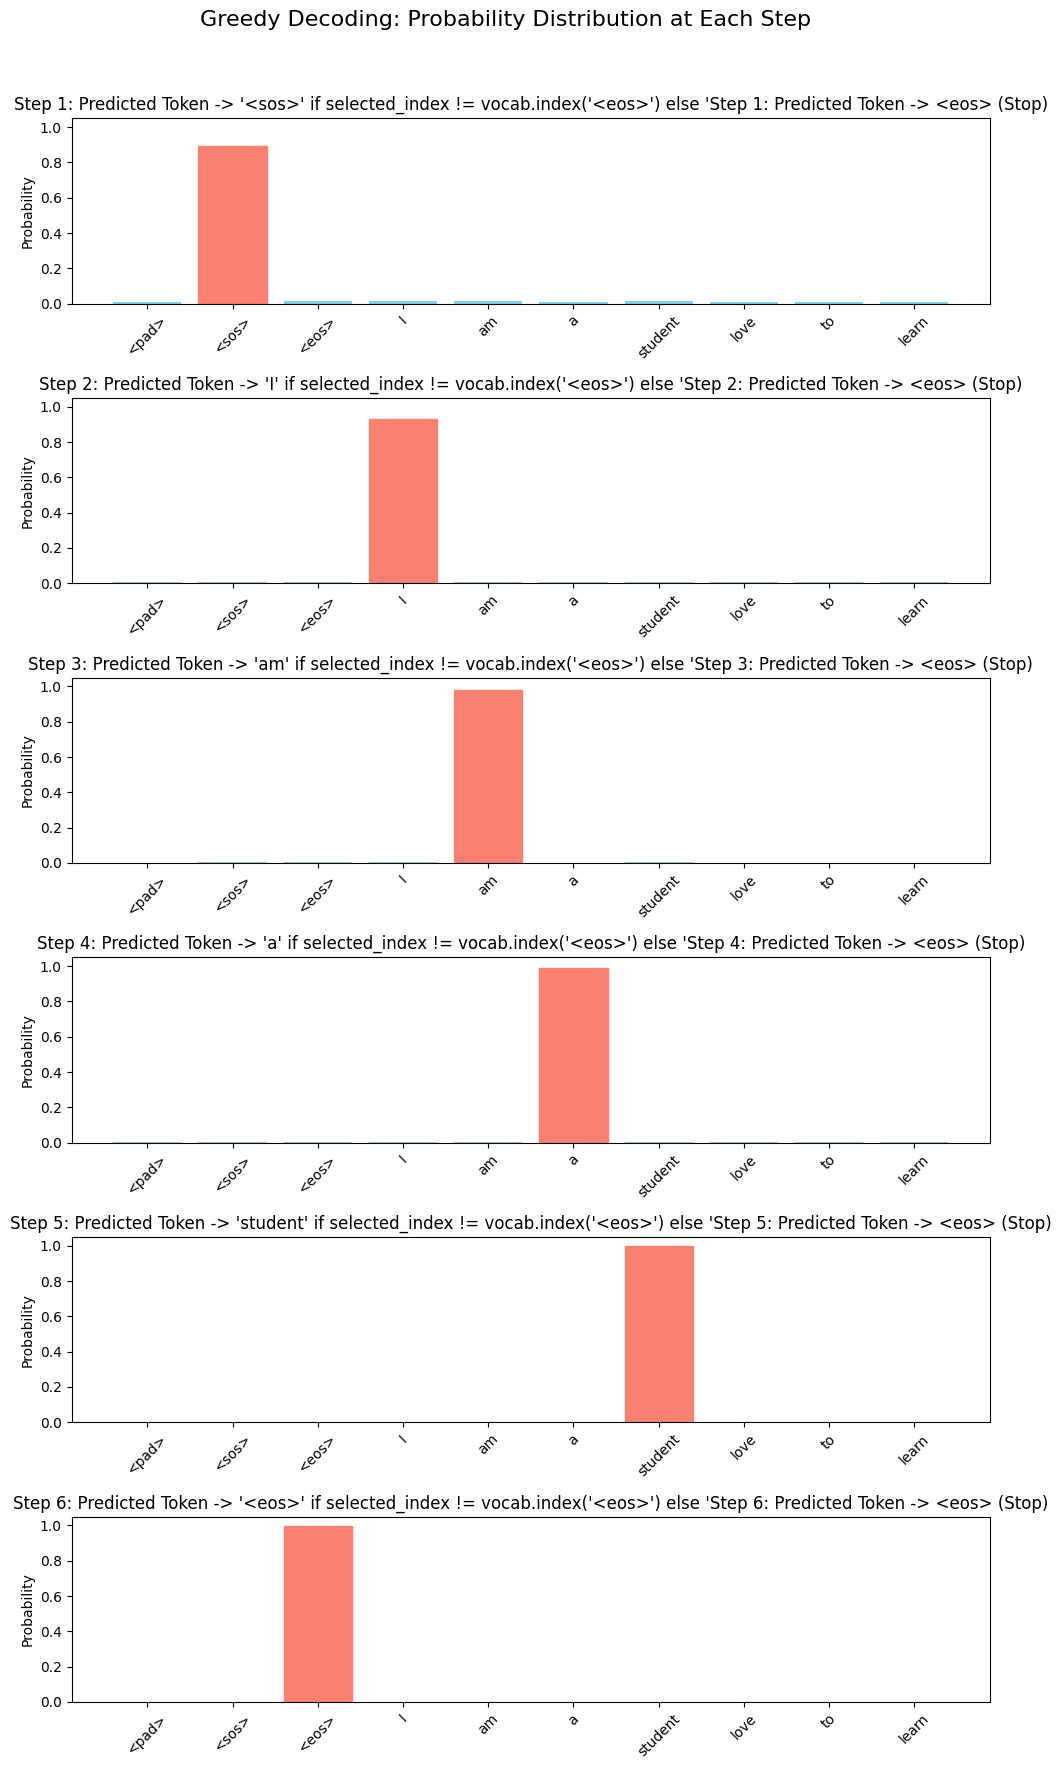

In [8]:
print(f"\n최종 생성된 문장: {' '.join(result_words)}")

# 각 스텝에서 확률 분포와 선택된 토큰 시각화
num_steps = len(result_indices) + 1 # 종료 토큰 스텝 포함
fig, axes = plt.subplots(num_steps, 1, figsize=(10, num_steps * 3))
fig.suptitle('Greedy Decoding: Probability Distribution at Each Step', fontsize=16)

for i in range(num_steps):
    ax = axes[i]
    probs = softmax(logits_over_time[i])
    selected_index = np.argmax(probs)
    
    bars = ax.bar(np.arange(vocab_size), probs, color='skyblue')
    ax.set_xticks(np.arange(vocab_size))
    ax.set_xticklabels(vocab, rotation=45)
    ax.set_ylabel('Probability')
    ax.set_title(f'Step {i+1}: Predicted Token -> \'{vocab[selected_index]}\' if selected_index != vocab.index(\'<eos>\') else \'Step {i+1}: Predicted Token -> <eos> (Stop)')
    ax.set_ylim(0, 1.05)
    
    # 가장 높은 확률의 막대 색상 변경
    bars[selected_index].set_color('salmon')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 고려사항 (Considerations)

* **최적성 문제:** 그리디 디코딩은 전체 시퀀스의 관점에서 최적의 해를 보장하지 않음. 예를 들어, 문장을 생성할 때 첫 단어로 약간 낮은 확률의 단어를 선택하는 것이 결국 전체적으로는 더 자연스러운 문장을 만들 수 있지만, 그리디 방식은 이 가능성을 탐색하지 않음.
* **반복 문제:** 특정 단어가 높은 확률을 계속해서 받으면, 같은 단어나 구문이 반복되는 현상이 발생하기 쉬움. ('I am am am am...')
* **대안 알고리즘:** 이러한 단점을 보완하기 위해 **빔 서치(Beam Search)**, **탑-k 샘플링(Top-k Sampling)**, **뉴클리어스 샘플링(Nucleus Sampling, Top-p)**과 같은 더 복잡한 디코딩 전략들이 사용됨. 이들은 여러 후보 시퀀스를 동시에 고려하거나 확률 분포에서 무작위 샘플링을 도입하여 더 다양하고 품질 높은 결과를 생성함.

## 최종 요약 (Conclusion)

본 노트북은 그리디 디코딩의 개념과 작동 방식을 단계별로 구현하여 살펴보았음. 그리디 디코딩은 매 스텝에서 가장 확률이 높은 토큰을 선택하는 직관적이고 빠른 시퀀스 생성 방법임. 예제에서는 미리 정의된 로짓(logits)을 사용하여, 각 스텝에서 Softmax 함수로 확률을 계산하고 `argmax`를 통해 다음 토큰을 결정하는 과정을 명확히 보여주었음.

시각화를 통해 각 단계의 확률 분포와 그리디 선택을 확인할 수 있었으며, 이는 알고리즘의 단순성과 결정론적(deterministic) 특성을 잘 나타냄. 그러나 국소적 최적 선택이 항상 전역적 최적해로 이어지지 않는다는 본질적인 한계점도 명확히 인지하는 것이 중요함.

# 🔄 대안 디코딩 알고리즘 비교 (Beam Search / Top-k / Nucleus Sampling)

이제 그리디 디코딩의 한계를 보완하기 위해 자주 사용되는 세 가지 대표적 대안 디코딩 기법을 살펴보고, 동일(또는 유사)한 실험 설정에서 작동 방식을 비교함.

- **Beam Search (빔 서치)**: 여러 개의 후보 시퀀스를 동시에 확장하며 전역적으로 더 높은 누적 확률을 추구.
- **Top-k Sampling**: 확률이 높은 상위 k개 후보만 남기고 그 중에서 확률적으로 샘플링하여 다양성 확보.
- **Nucleus (Top-p) Sampling**: 누적 확률이 p 이상이 되는 최소 토큰 집합을 동적으로 선택하고 그 안에서 샘플링.

각 기법은 (1) 탐색 폭 / (2) 확률적 다양성 / (3) 계산 비용 사이의 트레이드오프를 가짐.


## 1. Beam Search (빔 서치)

### 핵심 아이디어
그리디 디코딩은 매 스텝 하나의 경로만 유지하지만, 빔 서치는 상위 `B (beam width)`개의 부분 시퀀스를 동시에 유지하면서 확장함. 각 스텝에서 모든 빔에 대해 다음 토큰 확장을 시도한 뒤, (빔 수 × 어휘 수) 후보 중 누적 로그확률이 높은 상위 B개만 남김.

### 수식 표현
길이 t인 부분 시퀀스 y_{1:t} 의 점수(로그확률 합):

$$ \text{score}(y_{1:t}) = \sum_{i=1}^{t} \log P(y_i \mid y_{1:i-1}) $$

길이 보정(length penalty) 등을 적용할 수도 있으나 여기서는 단순 누적 로그확률을 사용.

### 장점
- 전역적으로 더 나은 시퀀스를 찾을 확률 증가
- 작은 B에서도 그리디보다 품질 향상 가능

### 단점
- 계산량: O(B * V * T)
- 여전히 결정론적 (동일 입력→동일 출력)

### 실험 설계
- 동일한 logits_over_time 사용
- beam width = 2, 3 비교
- 종료 토큰 <eos> 등장 시 해당 빔은 확장 중단


In [13]:
from math import log

def beam_search_decode(logits_sequence, vocab, beam_width=3, sos_token='<sos>', eos_token='<eos>'):
    """
    간단한 Beam Search 구현 (고정된 미리 계산된 logits 시퀀스를 순차적으로 소비)
    반환: (완성된 시퀀스 리스트, (시퀀스, 로그확률) 튜플 리스트)
    """
    eos_index = vocab.index(eos_token)
    max_steps = logits_sequence.shape[0]

    # 빔: 리스트[(토큰인덱스시퀀스, 누적로그확률)] - 초기엔 빈 시퀀스(또는 sos 제외)로 시작
    beams = [([], 0.0)]  # (sequence, log_prob)

    for t in range(max_steps):
        current_logits = logits_sequence[t]
        print(f"\n[스텝 {t + 1}] 현재 로짓: {current_logits}")
        probs = softmax(current_logits)
        log_probs = np.log(probs + 1e-12)
        print(f"  확률 분포(Probabilities): {probs}")

        new_beams = []
        for seq, lp in beams:
            # 이미 eos로 끝난 빔은 그대로 유지 (확장하지 않음)
            if len(seq) > 0 and seq[-1] == eos_index:
                new_beams.append((seq, lp))
                continue
            for token_idx, token_lp in enumerate(log_probs):
                new_seq = seq + [token_idx]
                new_beams.append((new_seq, lp + token_lp))

        # 상위 beam_width 선택
        new_beams.sort(key=lambda x: x[1], reverse=True)
        beams = new_beams[:beam_width]

        # 모든 빔이 eos로 끝나면 조기 종료
        if all(len(seq) > 0 and seq[-1] == eos_index for seq, _ in beams):
            break

    # 완성된(또는 최대 길이 도달) 빔을 확률 기준 정렬
    beams.sort(key=lambda x: x[1], reverse=True)

    # 단어 시퀀스로 변환(종료토큰 포함 제거 선택 가능)
    decoded = []
    for seq, lp in beams:
        words = [vocab[i] for i in seq if i != eos_index]
        decoded.append((words, lp))
    return decoded

# Beam Search 실행 예시
beam_results_bw2 = beam_search_decode(logits_over_time, vocab, beam_width=2)
beam_results_bw3 = beam_search_decode(logits_over_time, vocab, beam_width=3)

print('[Beam Width=2] 상위 결과:')
for words, lp in beam_results_bw2[:3]:
    print('  시퀀스:', ' '.join(words), '| 로그확률:', round(lp, 3))

print('\n[Beam Width=3] 상위 결과:')
for words, lp in beam_results_bw3[:3]:
    print('  시퀀스:', ' '.join(words), '| 로그확률:', round(lp, 3))


[스텝 1] 현재 로짓: [0.1 4.5 0.2 0.3 0.4 0.1 0.2 0.1 0.  0.1]
  확률 분포(Probabilities): [0.01097245 0.8937159  0.01212643 0.01340179 0.01481127 0.01097245
 0.01212643 0.01097245 0.00992829 0.01097245]

[스텝 2] 현재 로짓: [0.1 0.2 0.3 5.  0.4 0.1 0.2 0.1 0.  0.1]
  확률 분포(Probabilities): [0.00694559 0.00767606 0.00848337 0.9327219  0.00937557 0.00694559
 0.00767606 0.00694559 0.00628463 0.00694559]

[스텝 3] 현재 로짓: [0.1 0.2 0.3 0.4 6.2 0.1 0.2 0.1 0.  0.1]
  확률 분포(Probabilities): [0.00219518 0.00242605 0.0026812  0.00296318 0.9787364  0.00219518
 0.00242605 0.00219518 0.00198628 0.00219518]

[스텝 4] 현재 로짓: [0.1 0.2 0.3 0.4 0.1 7.1 0.2 0.1 0.  0.1]
  확률 분포(Probabilities): [9.0389804e-04 9.9896197e-04 1.1040239e-03 1.2201351e-03 9.0389804e-04
 9.9124461e-01 9.9896197e-04 9.0389804e-04 8.1788097e-04 9.0389804e-04]

[스텝 5] 현재 로짓: [0.1 0.2 0.3 0.1 0.1 0.1 8.9 0.1 0.  0.1]
  확률 분포(Probabilities): [1.5052375e-04 1.6635438e-04 1.8385009e-04 1.5052375e-04 1.5052375e-04
 1.5052375e-04 9.9861050e-01 1.5052375e-04

## 2. Top-k Sampling (탑-k 샘플링)

### 핵심 아이디어
각 스텝에서 확률이 가장 높은 상위 k개의 토큰만 남기고 나머지는 0으로 마스킹한 뒤(재정규화), 그 분포에서 무작위로 1개를 샘플링함. k=1이면 그리디와 동일.

### 알고리즘 절차
1. 확률 분포 P 얻기 (Softmax)
2. 상위 k개 토큰 인덱스 추출 (argsort / partial sort)
3. 나머지 확률 0 → 상위 k 확률만 남기고 재정규화
4. np.random.choice 로 샘플링

### 장점
- 단순, 구현 쉽고 다양성 증가

### 단점
- k 고정 → 실제 분포에서 tail이 얇을 때도 불필요하게 k 유지하거나, tail이 두꺼울 때 중요한 토큰 제외 가능

### 실험 설계
- k = 3, 5 비교
- 동일한 logits_over_time 사용 (재현성을 위해 seed 고정)


In [15]:
def top_k_sampling(logits_sequence, vocab, k=5, sos_token='<sos>', eos_token='<eos>', seed=42):
    np.random.seed(seed)
    eos_index = vocab.index(eos_token)
    generated_indices = []

    for t in range(logits_sequence.shape[0]):
        probs = softmax(logits_sequence[t])
        # 상위 k 인덱스
        top_k_indices = np.argsort(probs)[-k:][::-1]  # 내림차순
        top_k_probs = probs[top_k_indices]
        # 재정규화
        top_k_probs = top_k_probs / top_k_probs.sum()
        sampled = np.random.choice(top_k_indices, p=top_k_probs)
        if sampled == eos_index:
            break
        generated_indices.append(sampled)
        print(f"[스텝 {t + 1}] 선택된 토큰 인덱스: {sampled}, 단어: '{vocab[sampled]}'")
        
    words = [vocab[i] for i in generated_indices]
    return words, generated_indices

# 실행 예시
k3_words, k3_idx = top_k_sampling(logits_over_time, vocab, k=3, seed=1)
k5_words, k5_idx = top_k_sampling(logits_over_time, vocab, k=5, seed=1)
print('[Top-k k=3] 생성:', ' '.join(k3_words))
print('[Top-k k=5] 생성:', ' '.join(k5_words))

[스텝 1] 선택된 토큰 인덱스: 1, 단어: '<sos>'
[스텝 2] 선택된 토큰 인덱스: 3, 단어: 'I'
[스텝 3] 선택된 토큰 인덱스: 4, 단어: 'am'
[스텝 4] 선택된 토큰 인덱스: 5, 단어: 'a'
[스텝 5] 선택된 토큰 인덱스: 6, 단어: 'student'
[스텝 1] 선택된 토큰 인덱스: 1, 단어: '<sos>'
[스텝 2] 선택된 토큰 인덱스: 3, 단어: 'I'
[스텝 3] 선택된 토큰 인덱스: 4, 단어: 'am'
[스텝 4] 선택된 토큰 인덱스: 5, 단어: 'a'
[스텝 5] 선택된 토큰 인덱스: 6, 단어: 'student'
[Top-k k=3] 생성: <sos> I am a student
[Top-k k=5] 생성: <sos> I am a student


## 3. Nucleus (Top-p) Sampling (뉴클리어스 샘플링)

### 핵심 아이디어
Top-k는 k를 고정하지만 Top-p는 누적 확률이 임계값 p (예: 0.9)를 처음 초과하는 최소 토큰 집합만 유지하고 그 안에서 샘플링함. 분포의 엔트로피가 높을 때는 후보 폭이 넓어지고(다양성↑), 낮을 때는 좁아짐(안정성↑) → 적응형(adaptive) 방법.

### 알고리즘 절차
1. 확률 분포 P 정렬 (내림차순)
2. 누적합 계산, 누적합이 p 초과하는 지점까지 포함
3. 그 집합을 재정규화 후 샘플링

### 장점
- 분포 형태에 적응 → 불필요한 후보 제거 + 다양성 유지

### 단점
- p 설정 민감 (너무 낮으면 결정론적, 너무 높으면 험한 샘플)

### 실험 설계
- p = 0.8, 0.9 비교
- 동일 logits_over_time + seed 고정


In [16]:
def nucleus_sampling(logits_sequence, vocab, p=0.9, sos_token='<sos>', eos_token='<eos>', seed=123):
    np.random.seed(seed)
    eos_index = vocab.index(eos_token)
    generated_indices = []

    for t in range(logits_sequence.shape[0]):
        probs = softmax(logits_sequence[t])
        # 확률 내림차순 정렬
        sorted_indices = np.argsort(probs)[::-1]
        sorted_probs = probs[sorted_indices]
        cum_probs = np.cumsum(sorted_probs)
        # 누적확률 p 초과 전까지 유지
        cutoff_mask = cum_probs <= p
        # 첫번째로 p를 넘는 토큰도 포함해야 하므로
        if not np.all(cutoff_mask):
            first_exceed_idx = np.argmax(cum_probs > p)
            cutoff_mask[first_exceed_idx] = True
        nucleus_indices = sorted_indices[cutoff_mask]
        nucleus_probs = probs[nucleus_indices]
        nucleus_probs = nucleus_probs / nucleus_probs.sum()
        sampled = np.random.choice(nucleus_indices, p=nucleus_probs)
        if sampled == eos_index:
            break
        generated_indices.append(sampled)
        print(f"[스텝 {t + 1}] 선택된 토큰 인덱스: {sampled}, 단어: '{vocab[sampled]}'")
        
    words = [vocab[i] for i in generated_indices]
    return words, generated_indices

# 실행 예시
p08_words, p08_idx = nucleus_sampling(logits_over_time, vocab, p=0.8, seed=7)
p09_words, p09_idx = nucleus_sampling(logits_over_time, vocab, p=0.9, seed=7)
print('[Top-p p=0.8] 생성:', ' '.join(p08_words))
print('[Top-p p=0.9] 생성:', ' '.join(p09_words))

[스텝 1] 선택된 토큰 인덱스: 1, 단어: '<sos>'
[스텝 2] 선택된 토큰 인덱스: 3, 단어: 'I'
[스텝 3] 선택된 토큰 인덱스: 4, 단어: 'am'
[스텝 4] 선택된 토큰 인덱스: 5, 단어: 'a'
[스텝 5] 선택된 토큰 인덱스: 6, 단어: 'student'
[스텝 1] 선택된 토큰 인덱스: 1, 단어: '<sos>'
[스텝 2] 선택된 토큰 인덱스: 3, 단어: 'I'
[스텝 3] 선택된 토큰 인덱스: 4, 단어: 'am'
[스텝 4] 선택된 토큰 인덱스: 5, 단어: 'a'
[스텝 5] 선택된 토큰 인덱스: 6, 단어: 'student'
[Top-p p=0.8] 생성: <sos> I am a student
[Top-p p=0.9] 생성: <sos> I am a student


## 4. 알고리즘 비교 요약

| 알고리즘 | 결정론/확률 | 탐색 폭 | 다양성 | 계산비용 (상대) | 하이퍼파라미터 의미 |
|----------|-------------|---------|---------|----------------|----------------------|
| Greedy | 결정론 | 1 | 낮음 | 매우 낮음 | 없음 |
| Beam Search | 결정론 | Beam Width B | 낮음 (본질적) | 중간~높음 | B (빔 폭) |
| Top-k Sampling | 확률 | k (고정 상위) | 중간 | 낮음 | k (상위 후보 수) |
| Nucleus (Top-p) | 확률 | 동적 (누적 p까지) | 높음(적응형) | 낮음~중간 | p (누적 확률 임계) |

### 선택 가이드
- 빠르고 일관된 요약/번역: Greedy / 작은 Beam
- 약간 품질↑ (자연스러움): Beam Search
- 창의성/다양성 필요: Top-k (적절한 k)
- 의미 유지 + 자연스러운 다양성: Top-p (0.85~0.95 권장), 필요시 Top-k와 병행 (k, p 동시 제한)

### 추가 아이디어
- 반복 방지: n-gram 반복 금지 제약
- 온도(Temperature) 조절: logits / T → softmax (T>1 다양성↑, T<1 보수적)

이후 필요 시 온도 조절 + n-gram penalty 실험을 추가할 수 있음.


## 5. 확장 결론

그리디 디코딩에서 출발하여 Beam Search, Top-k, Nucleus Sampling을 구현/비교함으로써 시퀀스 생성의 핵심 트레이드오프인 (정확성 vs 다양성 vs 비용)을 확인함. 실제 애플리케이션에서는 다음과 같은 하이브리드 전략이 자주 사용됨:

- Top-p + (선택적) Top-k 동시 적용 (과도 확산 방지)
- Beam Search + 사후 다듬기 (re-ranking) (예: 길이 보정, 커버리지 penalty)
- Temperature + Top-p 조합 → 사용자 성향에 따른 창의성 조절

추가로 반복 억제(n-gram blocking), 금지 토큰 리스트, 문맥 기반 동적 p 조절 등이 품질 향상에 활용됨.

이 노트북을 바탕으로 실제 언어 모델 출력(logits)을 연결하면 보다 현실적인 실험이 가능함.
